# 1. Example: DataAssimBench basics and generating data from Lorenz63 model

In this notebook, we will introduce the basic principles DataAssimBench and generate data from the most simple model in the library: the Lorenz 1963 model.

### Part I: Import dabench.data

The "data" sub-package is dabench's interface for generating and loading datasets.

In [1]:
from dabench import data

In [2]:
# Running help on data shows that available data classes (under the heading "CLASSES")
help(data) 

Help on package dabench.data in dabench:

NAME
    dabench.data

PACKAGE CONTENTS
    _data
    _utils
    aws
    barotropic
    enso_indices
    gcp
    lorenz63
    lorenz96
    pyqg
    sqgturb

CLASSES
    builtins.object
        dabench.data._data.Data
            dabench.data.aws.AWS
            dabench.data.barotropic.Barotropic
            dabench.data.enso_indices.ENSOIndices
            dabench.data.gcp.GCP
            dabench.data.lorenz63.Lorenz63
            dabench.data.lorenz96.Lorenz96
            dabench.data.pyqg.PyQG
            dabench.data.sqgturb.SQGTurb
    
    class AWS(dabench.data._data.Data)
     |  AWS(variables=['air_temperature_at_2_metres'], months=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], years=[2020], min_lat=19.8554808619, max_lat=23.1886107447, min_lon=-84.9749110583, max_lon=-74.1780248685, system_dim=None, time_dim=None, store_as_jax=False, **kwargs)
     |  
     |  Class for loading ERA5 data from AWS Open Data
  

In [3]:
# We can get more info about a particular class by running help() on it
help(data.Lorenz63)

Help on class Lorenz63 in module dabench.data.lorenz63:

class Lorenz63(dabench.data._data.Data)
 |  Lorenz63(sigma=10.0, rho=28.0, beta=2.6666666666666665, delta_t=0.01, x0=DeviceArray([-10. , -15. ,  21.3], dtype=float32), system_dim=3, time_dim=None, values=None, store_as_jax=False, **kwargs)
 |  
 |  Class to set up Lorenz 63 model data
 |  
 |  Attributes:
 |      sigma (float): Lorenz 63 param. Default is 10., the original value
 |          used in Lorenz, 1963.
 |          https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2
 |      rho (float): Lorenz 63 param. Default is 28., the value used in
 |          Lorenz, 1963 (see DOI above)
 |      beta (float): Lorenz 63 param. Default is 8./3., the value used in
 |          Lorenz, 1963 (see DOI above)
 |      x0 (ndarray, float): Initial state, array of floats of size
 |          (system_dim). Default is jnp.array([-10.0, -15.0, 21.3]), which
 |          is the system state after a 6000 step spinup with delta_t=0.01
 |    

As we can see, this class implements the model first published in Lorenz, 1963:https://doi.org/10.1175/1520-0469(1963)020%3C0130:DNF%3E2.0.CO;2

This is a three-variable model. By default, our initial state (x0) is [-10.0, -15.0, 21.3].

In addition to the the initial state, there are three paramaters: sigma, rho, and beta. All of these have sensible defaults (taken from the original Lorenz 1963 paper) so there is no reason to tweak them unless we want to customize our model settings. 

### Part II: Create model object and generate data

To generate data from a dabench.data model, we first create a model object. If we want, this is where we can change the parameters and initial state of the model. But for starters, let's just stick with the defaults.

In [4]:
l63_model = data.Lorenz63()

In [5]:
# Generating data is as easy as using the .generate() method. This is the same for all models in dabench.data(). 
# We must specify n_steps to determine how long we want our model to run. Let's start with 1000
l63_model.generate(n_steps=1000)

### Part III: Examine generated data

The generated data for the Lorenz63 model is accessed as l63_model.values. This is the same scheme for all models/data loaders in dabench.data.

In [6]:
# We can see how we start with the initial condition [-10.0, -15.0, 21.3] and proceed from there
print(l63_model.values)

[[-10.       -15.        21.3     ]
 [-10.499835 -15.48437   22.282291]
 [-10.994274 -15.884403  23.360668]
 ...
 [ 14.970768  18.057531  32.537518]
 [ 15.218436  17.060793  34.3015  ]
 [ 15.335094  15.809253  35.88078 ]]


In [7]:
# Shape is (n_steps, system_dim), in this case (1000, 3)
print(l63_model.values.shape)

(1000, 3)


In [8]:
# Let's plot our data using matplotlib
import matplotlib.pyplot as plt

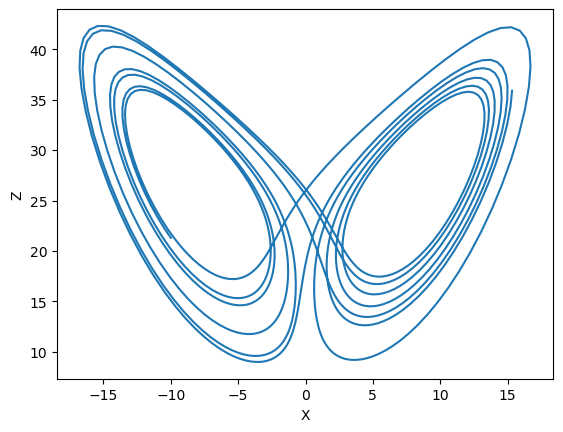

In [9]:
# Since we have 3 variables in our model (X, Y, and Z), let's choose X and Z for plotting in 2D
plt.plot(l63_model.values[:,0], l63_model.values[:,2])
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

Lorenz63 is famous for it's "butterfly" attractor shape. You should be able to see that in the plot above

### Part IV: Demonstrating chaos - tweaking initial conditions


The Lorenz, 1963 paper is famous for demonstrating the idea of "chaos", meaning that _minutely_ different initial conditions eventually result in wildly divergent outcomes. Let's test that here by tweaking in the intitial conditions.

In [10]:
import numpy as np

In [11]:
# Add 0.01 to Z in the initial state
new_x0 = l63_model.x0 + np.array([0, 0, 0.01])
print(new_x0)

[-10.         -15.          21.30999924]


In [12]:
l63_new = data.Lorenz63(x0=new_x0)
l63_new.generate(n_steps=1000)

In [13]:
# Now let's compare the final timesteps for our old and new model
print('Previous final values:', l63_model.values[-1])
print('New final values:', l63_new.values[-1])

Previous final values: [15.335094 15.809253 35.88078 ]
New final values: [-1.01676812 -2.04624518  5.16487998]


We can see that we have wildly different outcomes despite a very small change to the initial conditions. This is the basic principle of chaos in weather modeling.

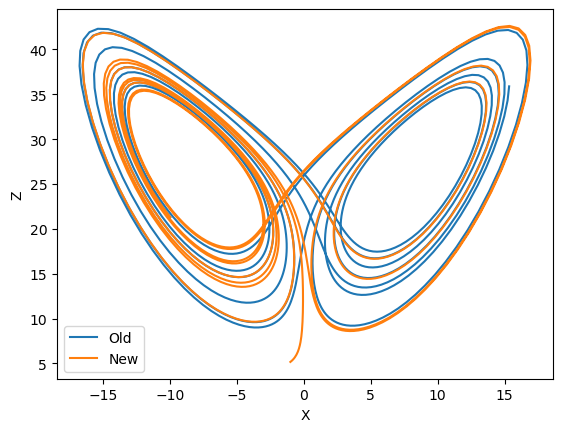

In [14]:
# Despite having different outcomes, the two model trajectories have very similar overall shapes
plt.plot(l63_model.values[:,0], l63_model.values[:,2], label="Old")
plt.plot(l63_new.values[:,0], l63_new.values[:,2], label='New')
plt.xlabel('X')
plt.ylabel('Z')
plt.legend()
plt.show()

## Wrapping UP

That's it for the basics of dabench data generators! Feel free to experiment with changing the Lorenz63 parameters or the length of the run (n_steps). You can also try a different model like Lorenz96, which is a bit more complex, or go to the next example notebook for an even more complex "surface quasi-geostrophic turbulence" (sqgturb) model. 